### 1. Importar las bibliotecas requeridas

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import yaml
%matplotlib inline
from google.colab import drive

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
print('My tensorflow version is...')
print(tf.__version__)

My tensorflow version is...
2.5.0


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Exploración de training y testing set

In [ ]:
path_train = '/content/drive/MyDrive/Colab Notebooks/11. Titanic machine learning/train.csv'
path_test = '/content/drive/MyDrive/Colab Notebooks/11. Titanic machine learning/test.csv'

In [ ]:
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

In [ ]:
df = train.append(test, ignore_index=True)

In [ ]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [ ]:
# Número de valores únicos por cada columna.

for col in df.columns:
    print('{}:'.format(col), len(df['{}'.format(col)].unique()))

PassengerId: 1309
Survived: 3
Pclass: 3
Name: 1307
Sex: 2
Age: 99
SibSp: 7
Parch: 8
Ticket: 929
Fare: 282
Cabin: 187
Embarked: 4


**No vale la pena incluir la columna "Cabin" ya que posee un total de 187 valores únicos y tan solo hay 295 filas con datos, la gran mayoría está vacía.**

**No vale la pena incluir la columna Ticket puesto que tiene 929 valores únicos, además que el ticket debería estar altamente correlacionado a la clase en la que el pasajero viajaba y al precio que este pagó.**

In [ ]:
df[['Age', 'SibSp', 'Parch', 'Fare']].describe()

,Age,SibSp,Parch,Fare
count,1046.000000,1309.000000,1309.000000,1308.000000
mean,29.881138,0.498854,0.385027,33.295479
std,14.413493,1.041658,0.865560,51.758668
min,0.170000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,14.454200
75%,39.000000,1.000000,0.000000,31.275000
max,80.000000,8.000000,9.000000,512.329200


**¿Qué pasa con las celdas de la columna "Fare" que están en 0? ¿Cuáles son estas? ¿Son valores que hacen falta o realmente tuvieron un costo de $0?**

In [ ]:
print(len(df[df['Fare'] == 0]))
df[df['Fare'] == 0]

17


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [ ]:
fare_0 = df[df['Fare'] == 0]
print(fare_0['Pclass'].value_counts())

1    7
2    6
3    4
Name: Pclass, dtype: int64


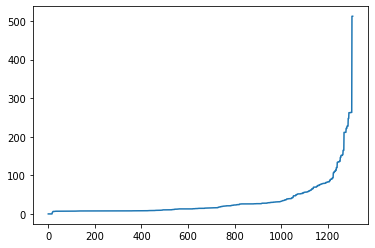

In [ ]:
fare_graph = df['Fare'].sort_values(ignore_index=True)
fare_graph.plot(kind='line')

**Hay 15 tickets en total con un precio de 0 dólares. 5 son de personas que viajaban en 1ra clase, 6 eb 2da clase, y 4 en 3ra clase. Asumiremos que el valor del ticket para estas personas fue de 0, y NO lo tomaremos como un valor faltante.**

**La columna "Embarked" tiene dos celdas vacías o sin datos. ¿Cuáles son estas? ¿Por qué estos dos registros tienen el mismo número de ticket?**

In [ ]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [ ]:
tickets_same_number = {}

for ticket in df['Ticket']:
    if ticket not in tickets_same_number:
        tickets_same_number[ticket] = 1
    else:
        tickets_same_number[ticket] += 1

In [ ]:
newDict = dict()

for (key, value) in tickets_same_number.items():
    if value >= 4:
        newDict[key] = value
print(len(newDict))
print(newDict)

35
{'349909': 5, '347082': 7, '382652': 6, '347077': 7, '19950': 6, 'SC/Paris 2123': 4, '3101295': 7, 'C.A. 34651': 4, 'CA 2144': 8, '347088': 6, 'S.O.C. 14879': 7, '1601': 8, 'W./C. 6608': 5, 'C.A. 2315': 4, 'C.A. 33112': 4, 'CA. 2343': 11, '4133': 5, 'LINE': 4, '230136': 4, 'PC 17755': 4, 'PC 17760': 4, '113781': 6, '17421': 4, 'PC 17608': 7, '36928': 4, '16966': 5, '113503': 5, 'PC 17757': 5, '113760': 4, '2666': 4, '12749': 4, 'PC 17483': 4, '220845': 5, '24160': 4, 'W./C. 6607': 4}


In [ ]:
df[df['Ticket']=='347088']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
63,64,0.0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9,NaN,S
167,168,0.0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9,NaN,S
360,361,0.0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9,NaN,S
634,635,0.0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,NaN,S
642,643,0.0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9,NaN,S
819,820,0.0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9,NaN,S


**Hay 19 números de ticket que se repiten en la base de datos más de cuatro veces. Parece ser que estas son personas que viajaban acompañadas con hermanos, padres, esposos, o hijos. Este puede ser un buen dato a tomar en cuenta para la predicción.**

### 3. Data cleaning y feature engineering

#### 3.1 Eliminar la columna "Cabin" y "Ticket".

In [ ]:
df = df.drop('Ticket', axis = 1)
df = df.drop('Cabin', axis = 1)

#### 3.2 Extraer el título de la persona a partir de "Name".

**El rendimiento del modelo aumentó al incluir esta característica, pero solo en este modelo.**

In [ ]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
print(df['Title'].unique())

summarized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"}

df.Title = df.Title.map(summarized_titles)
print(df['Title'].value_counts())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']
Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64


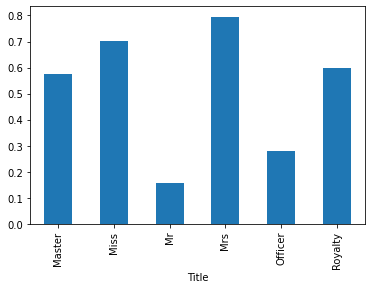

In [ ]:
df[['Title', 'Survived']].groupby('Title')['Survived'].mean().plot(kind='bar')

#### 3.3 Imputar valores en blanco de "Embarked" según la moda.

In [ ]:
print(df['Embarked'].value_counts())

S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [ ]:
df['Embarked'] = df['Embarked'].fillna(value = 'S')

#### 3.4 Imputar valores en blanco de "Age" basado en el promedio.

In [ ]:
df.groupby(['Sex', 'Pclass', 'Title'])['Age'].mean()

Sex     Pclass  Title  
female  1       Miss       30.131148
                Mrs        42.926471
                Officer    49.000000
                Royalty    40.000000
        2       Miss       20.717083
                Mrs        33.418182
        3       Miss       17.360874
                Mrs        32.326531
male    1       Master      6.984000
                Mr         41.450758
                Officer    51.090909
                Royalty    42.333333
        2       Master      2.757273
                Mr         32.346715
                Officer    40.700000
        3       Master      6.090000
                Mr         28.318910
Name: Age, dtype: float64

In [ ]:
df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.mean()))

#### 3.5 Convertir las edades de "Age" a rangos de 4 categorías.

In [ ]:
df['Age'] = pd.cut(df['Age'], bins=[-1,16,32,64,120], right=True, 
                        labels=False)

In [ ]:
df['Age'].value_counts()

1    710
2    444
0    142
3     13
Name: Age, dtype: int64

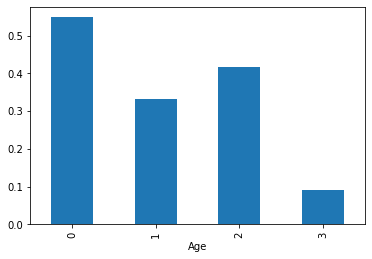

In [ ]:
df[['Age', 'Survived']].groupby('Age')['Survived'].mean().plot(kind='bar')

#### 3.6 Imputar valores en blanco de Fare basado en el promedio.

In [ ]:
df.groupby(['Pclass', 'Title'])['Fare'].mean()

Pclass  Title  
1       Master     150.056660
        Miss       127.934544
        Mr          68.260090
        Mrs         96.955288
        Officer     65.204808
        Royalty     53.275000
2       Master      27.386745
        Miss        22.571500
        Mr          19.527443
        Mrs         23.827084
        Officer     17.337500
3       Master      25.443609
        Miss        14.375697
        Mr          11.103904
        Mrs         17.480050
Name: Fare, dtype: float64

In [ ]:
df['Fare'] = df.groupby(['Pclass', 'Title'])['Fare'].apply(lambda x: x.fillna(x.mean()))

#### 3.7 Convertir las precios de "Fare" a rangos de 3 categorías.

In [ ]:
df['Fare'] = pd.cut(df['Fare'], bins=[-1,10.5,41.6,515], right=True, 
                        labels=False)

In [ ]:
df['Fare'].value_counts()

0    529
1    521
2    259
Name: Fare, dtype: int64

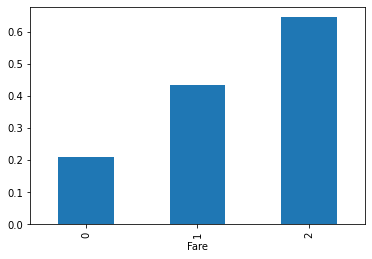

In [ ]:
df[['Fare', 'Survived']].groupby('Fare')['Survived'].mean().plot(kind='bar')

#### 3.8 Crear columna con el total de acompañantes.

In [ ]:
df['TotalAcompañantes'] = df['SibSp'] + df['Parch']

#### 3.9 Convertir el no. de acompañantes a rangos de 2 categorías.

In [ ]:
df['Acompañantes'] = pd.cut(df['TotalAcompañantes'], bins=[-1,0,3,12], right=True, 
                        labels=False)

In [ ]:
df['Acompañantes'].value_counts()

0    790
1    437
2     82
Name: Acompañantes, dtype: int64

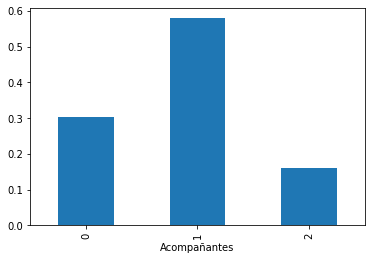

In [ ]:
df[['Acompañantes', 'Survived']].groupby('Acompañantes')['Survived'].mean().plot(kind='bar')

#### 3.10 Convertir "Sex" y "Embarked" a código númerico.

In [ ]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [ ]:
df['Title'] = df['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Officer': 4, 'Royalty': 5})

In [ ]:
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

#### 3.11 Eliminar la columnas de "SibSp" y "Parch".

In [ ]:
df = df.drop('Name', axis = 1)
df = df.drop('SibSp', axis = 1)
df = df.drop('Parch', axis = 1)

#### 3.11 Explorar base de datos limpia y con nuevos features.

In [ ]:
df.head(3)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,TotalAcompañantes,Acompañantes
0,1,0.0,3,0,1,0,0,0,1,1
1,2,1.0,1,1,2,2,1,2,1,1
2,3,1.0,3,1,1,0,0,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PassengerId        1309 non-null   int64  
 1   Survived           891 non-null    float64
 2   Pclass             1309 non-null   int64  
 3   Sex                1309 non-null   int64  
 4   Age                1309 non-null   int64  
 5   Fare               1309 non-null   int64  
 6   Embarked           1309 non-null   int64  
 7   Title              1309 non-null   int64  
 8   TotalAcompañantes  1309 non-null   int64  
 9   Acompañantes       1309 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 102.4 KB


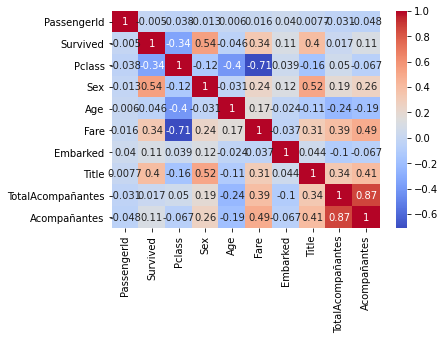

In [ ]:
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm')

### 4. Separación de training y testing set

In [ ]:
train_cleaned = df.loc[:890]
test_cleaned = df.loc[891:].reset_index(drop=True)

In [ ]:
y_train = train_cleaned['Survived'].values
y_train = to_categorical(y_train, 2)
x_train = train_cleaned.drop(['PassengerId', 'Survived'], axis=1).values

In [ ]:
x_test = test_cleaned.drop(['PassengerId', 'Survived'], axis=1).values
id_test = test_cleaned['PassengerId']

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(891, 8)
(891, 2)
(418, 8)


#### 4.1 Normalize all the features.

In [ ]:
normalizer = preprocessing.StandardScaler()
normalizer = normalizer.fit(x_train)

In [ ]:
x_train = normalizer.transform(x_train)

In [ ]:
print(normalizer.mean_)

[2.30864198 0.35241302 1.24915825 0.78563412 0.36139169 0.73512907
 0.90460157 0.46689113]


In [ ]:
x_test = normalizer.transform(x_test)

### 5. Multi-Layer Perceptron deep learning model

In [ ]:
# shape of the input
input_shape = (8,)

#set up model
model = Sequential()

model.add(Dense(units = 32, input_shape = input_shape, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 4, activation='relu'))
model.add(Dense(units = 2, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 3

#### 5.1 Training del modelo.

In [ ]:
# habilitar opción para guardar los pesos del mejor modelo.

filepath= 'best_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

In [ ]:
callbacks_list = [checkpoint]

In [ ]:
# training del modelo.

model.fit(x=x_train, y=y_train, epochs=300, batch_size=100, verbose=2, 
          validation_split=0.1, callbacks = callbacks_list)

Epoch 1/300
9/9 - 1s - loss: 0.6849 - accuracy: 0.5456 - val_loss: 0.6667 - val_accuracy: 0.6778

Epoch 00001: val_loss improved from inf to 0.66671, saving model to best_weights.hdf5
Epoch 2/300
9/9 - 0s - loss: 0.6676 - accuracy: 0.5880 - val_loss: 0.6584 - val_accuracy: 0.7444

Epoch 00002: val_loss improved from 0.66671 to 0.65839, saving model to best_weights.hdf5
Epoch 3/300
9/9 - 0s - loss: 0.6714 - accuracy: 0.5593 - val_loss: 0.6488 - val_accuracy: 0.7556

Epoch 00003: val_loss improved from 0.65839 to 0.64883, saving model to best_weights.hdf5
Epoch 4/300
9/9 - 0s - loss: 0.6536 - accuracy: 0.6005 - val_loss: 0.6369 - val_accuracy: 0.7444

Epoch 00004: val_loss improved from 0.64883 to 0.63686, saving model to best_weights.hdf5
Epoch 5/300
9/9 - 0s - loss: 0.6606 - accuracy: 0.5980 - val_loss: 0.6229 - val_accuracy: 0.7111

Epoch 00005: val_loss improved from 0.63686 to 0.62293, saving model to best_weights.hdf5
Epoch 6/300
9/9 - 0s - loss: 0.6518 - accuracy: 0.6130 - val_los

In [ ]:
# guardar la arquitectura del modelo.

yaml_string = model.to_yaml() 
with open('/content/drive/MyDrive/Colab Notebooks/11. Titanic machine learning/mlp_model.yml', 'w') as outfile:
    outfile.write(yaml.dump(yaml_string, default_flow_style=True))

#### 5.3 Testing del modelo en testing set.

In [ ]:
# cargar la arquitectura del modelo y sus pesos.

with open('/content/drive/MyDrive/Colab Notebooks/11. Titanic machine learning/mlp_model.yml', 'r') as f:
        yaml_string = yaml.load(f)
model.load_weights('best_weights.hdf5')
# model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
print('model and weights are ready!')

model and weights are ready!


In [ ]:
mlp_pred = model.predict_classes(x_test)
mlp_pred = pd.Series(mlp_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
predictions = pd.DataFrame({'PassengerId': id_test, 'Survived': mlp_pred})

In [ ]:
predictions.to_csv('/content/drive/MyDrive/Colab Notebooks/11. Titanic machine learning/predictions.csv', index = False) 

**MLP deep learning model logró un accuracy en el testing set de Kaggle de 78.23%. Favor ver el otro notebook dentro de este mismo repositorio para ver el código del mejor modelo: Random forest.**